<a href="https://colab.research.google.com/github/vmazashvili/Neural-Networks/blob/main/MaskTune_Vano_Mazashvili_1993251.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MaskTune Model

- train an ERM Model (Empirical Risk Minimization)
    - Load and normalize the CIFAR10 training and test datasets using torchvision

    - Define a Convolutional Neural Network

    - Define a loss function

    - Train the network on the training data

Test the network on the test data
- Generate Masks based on Model Outputs
- Fine-tune the Model with Masks
- Testing and Evaluation

In [36]:
!pip install torch torchvision timm
!pip install torchcam
!pip install pytorch-gradcam

In [64]:
import cv2
import timm
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchcam.methods import XGradCAM
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

Load and normalize the MNIST training and test datasets using torchvision



In [38]:
training_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [39]:
training_data[0][0].shape

torch.Size([1, 28, 28])

In [40]:
len(training_data)

60000

# Draw random numbers from the dataset with their lables
Just a visual verification step confirming that we correctly loaded the dataset.

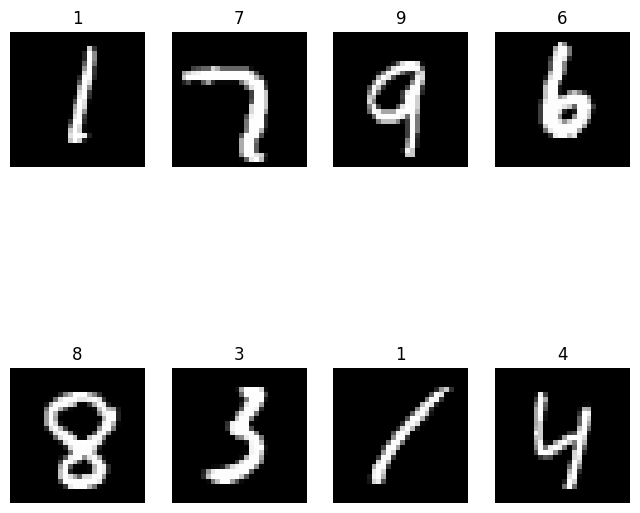

In [41]:
figure = plt.figure(figsize=(8,8))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Dataloaders
make batches

In [42]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
len(test_dataloader)

157

# Define CNN
Define a Convolutional Neural Network and give its class a ```get_grad_cam_target_layer``` function which will grab the last convolutional layer to use it for saliency map generation

In [43]:
# Small Convolutional Neural Network

class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Conv2d(16, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Flatten()
        )

        self.linear = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.linear(features)
        return logits


    def get_grad_cam_target_layer(self):
        return self.backbone[-5]


### Hyperparameters, optimizer, model selection

In [71]:
# hyperparameters

lr = 0.001
batch_size = 64
epochs = 10
number_of_classes = 10

loss_function = nn.CrossEntropyLoss()

# in base_method.py check how we can pass the tailored parameters to the CNN. 10
model = SmallCNN(number_of_classes)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

model

SmallCNN(
  (backbone): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=

# Training and Testing
Done with the specified parameters and models above

In [45]:
# training

def train_erm (model):
    for xb, yb in train_dataloader:
        preds = model(xb)
        loss = loss_function(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = loss.item()
    print(f"Train loss: {loss:>7f}")

    # Save the model's state dictionary
    torch.save(model.state_dict(), '/content/data/MNIST/CNN_checkpoint.pth')

In [46]:
# testing

def test_model (model):
    num_batches = len(test_dataloader)
    size = len(test_dataloader.dataset)
    test_loss, corrects = 0,0

    with torch.no_grad():
        for xb, yb in test_dataloader:
            preds=model(xb)
            test_loss += loss_function(preds,yb).item()
            corrects += (preds.argmax(1) == yb).type(torch.float).sum().item()

    test_loss /= num_batches
    corrects /= size
    print(f"Test loss: \n Accuracy:{(100*corrects):>0.1f}%, Avg loss:{test_loss:>8f}\n")

In [48]:
for t in range(4):
    train_erm(model)
    test_model(model)

Train loss: 0.199554
Test loss: 
 Accuracy:95.4%, Avg loss:0.269966

Train loss: 0.132713
Test loss: 
 Accuracy:96.3%, Avg loss:0.196773

Train loss: 0.101016
Test loss: 
 Accuracy:96.8%, Avg loss:0.158724

Train loss: 0.082700
Test loss: 
 Accuracy:97.1%, Avg loss:0.135219



# Generating Saliency Map using XGradCAM
Implementing explainability.
Using the, for example, last convolutional layer from the trained CNN checkpoint to generate the gradient and hook.
Pass a random instance from each class to the trained model. The model, target layer from the trained network and the network output are used to generate a saliency_map which is interpolated and projected onto the appropriate input image.

In [52]:
def generate_map(sample_data, sample_class):
    checkpoint = torch.load('/content/data/MNIST/CNN_checkpoint.pth') # Load the saved model checkpoint
    model.load_state_dict(checkpoint)
    # Don’t forget to set your model into the evaluation mode, otherwise you can get very random results
    model.eval() # Set the model to evaluation mode

    # Get the target layer
    target_layer = model.get_grad_cam_target_layer() # Last convolutional layer is the target
    # Prepare the input tensor
    input_tensor = sample_data # a sample from the dataset passed to the function

    cam = XGradCAM(model, target_layer)
    output = model (input_tensor.unsqueeze(0))
    saliency_map = cam(class_idx = sample_class, scores = output)

    # Now we can visualize the saliency map
    # Get the first saliency map tensor from the list
    saliency_map_tensor = saliency_map[0]

    # Convert the saliency map tensor to a numpy array
    saliency_map_np = saliency_map_tensor.detach().cpu().numpy()

    # Reshape the saliency map to 2D
    saliency_map_np = saliency_map_np.reshape(saliency_map_np.shape[1:])

    # Visualize or process the saliency map as needed
    # For example, you can plot it as an image
    #plt.imshow(saliency_map_np, cmap='hot', interpolation='nearest')
    #plt.axis('off')
    #plt.show()

    return saliency_map_np

In [50]:
def interpolate_heatmap(input_tensor, saliency_map_np):
    # Convert the input tensor to a numpy array image
    input_img_np = input_tensor.squeeze(0).cpu().numpy()
    input_img_np = np.uint8(255 * input_img_np)

    # Resize the saliency map to match the size of the original image
    heatmap_resized = cv2.resize(saliency_map_np, (input_img_np.shape[1], input_img_np.shape[0]))

    # Normalize the saliency map values to the range [0, 255]
    heatmap_resized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized)) * 255
    heatmap_resized = np.uint8(heatmap_resized)

    # Convert the original image to a BGR format
    input_img_bgr = cv2.cvtColor(input_img_np, cv2.COLOR_GRAY2BGR)

    # Apply a colormap to the saliency map to convert it into a heatmap image
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Resize the heatmap image to match the size of the original image
    heatmap_colored_resized = cv2.resize(heatmap_colored, (input_img_np.shape[1], input_img_np.shape[0]))

    # Overlay the heatmap image onto the original image
    superimposed_img = cv2.addWeighted(input_img_bgr, 0.7, heatmap_colored_resized, 0.3, 0)

    return superimposed_img


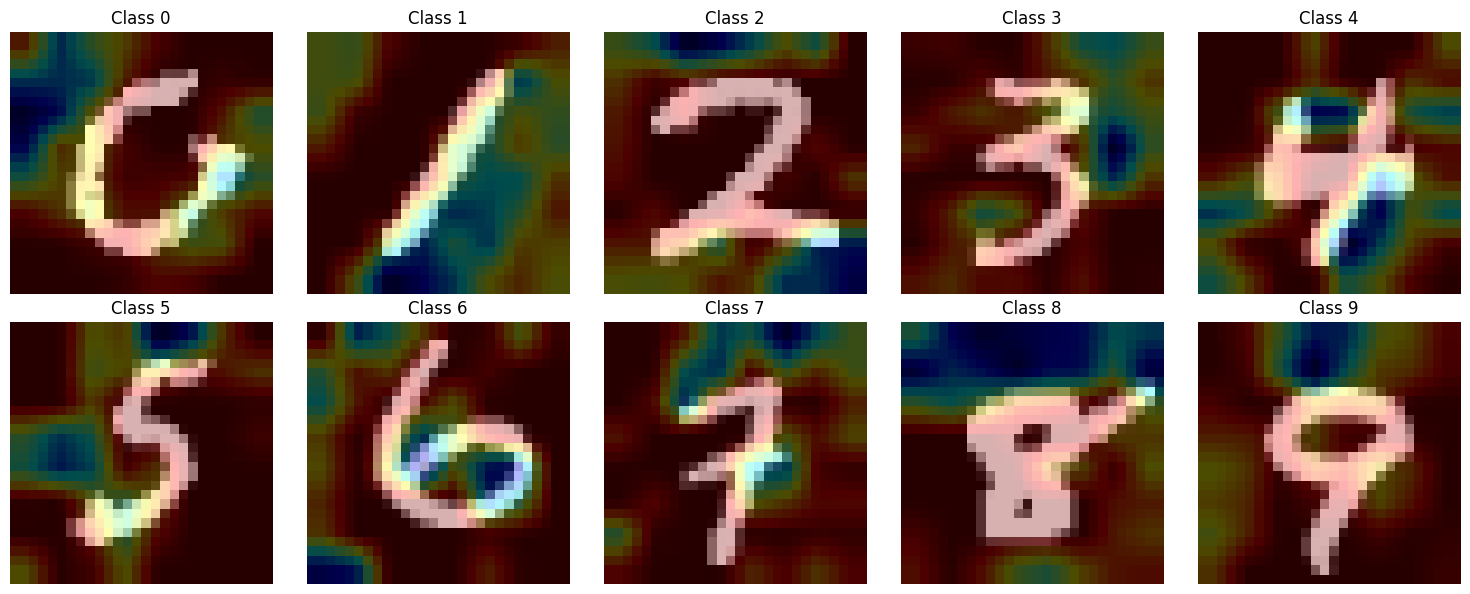

In [59]:
import random

# Dictionary to store interpolated images by class label
interpolated_images_by_class = {}

# Function to generate and interpolate the heatmap for one instance of each class
def generate_and_interpolate_heatmap_one_per_class():
    # Iterate through each class label
    for class_label in range(10):  # Assuming 10 classes (0 to 9)
        # Get the data instances for the specified class label
        class_data = class_data_dict.get(class_label, [])

        # Select one random instance from the class data
        if class_data:
            random_instance = random.choice(class_data)

            # Generate the saliency map for the random instance
            saliency_map_np = generate_map(random_instance, class_label)

            # Interpolate the heatmap for the random instance
            interpolated_img = interpolate_heatmap(random_instance, saliency_map_np)

            # Store the interpolated image in the dictionary by class label
            interpolated_images_by_class[class_label] = interpolated_img

# Generate interpolated images for one instance per class
generate_and_interpolate_heatmap_one_per_class()

# Plot the interpolated images with their class labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    class_label = i
    interpolated_img = interpolated_images_by_class.get(class_label)
    if interpolated_img is not None:
        ax.imshow(interpolated_img, cmap='hot', interpolation='nearest')
        ax.axis('off')
        ax.set_title(f'Class {class_label}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [74]:
import torch
import numpy as np
import cv2

def accumulate_and_plot_average_saliency_map(training_data, generate_map, class_label_to_accumulate, num_maps_to_accumulate=10):
    # List to store accumulated saliency maps for the chosen class label
    accumulated_saliency_maps = []

    # Function to accumulate the input tensors for the chosen class label
    def accumulate_inputs():
        # List to store accumulated input tensors for the chosen class label
        accumulated_inputs = []

        # Iterate through the training data
        for data in training_data:
            input_tensor, class_label = data

            # Check if the class label matches the chosen class label
            if class_label == class_label_to_accumulate:
                # Accumulate the input tensor
                accumulated_inputs.append(input_tensor)

        return accumulated_inputs

    # Accumulate the input tensors for the chosen class label
    accumulated_inputs = accumulate_inputs()

    # Function to generate and accumulate the saliency maps for the chosen class label
    def accumulate_saliency_maps():
        nonlocal accumulated_saliency_maps
        # Generate saliency maps for the chosen class label
        for _ in range(num_maps_to_accumulate):
            # Choose a random input tensor from the accumulated inputs
            input_tensor = random.choice(accumulated_inputs)

            # Generate the saliency map for the chosen input tensor
            saliency_map = generate_map(input_tensor, class_label_to_accumulate)

            # Accumulate the saliency map
            accumulated_saliency_maps.append(saliency_map)

    # Generate and accumulate saliency maps for the chosen class label
    accumulate_saliency_maps()

    # Convert the list of accumulated saliency maps to a numpy array
    accumulated_saliency_maps_array = np.array(accumulated_saliency_maps)

    # Compute the average saliency map
    average_saliency_map = np.mean(accumulated_saliency_maps_array, axis=0)

    # Interpolate the average saliency map to match the size of the original input image (28x28)
    interpolated_avg_saliency_map = cv2.resize(average_saliency_map, (28, 28), interpolation=cv2.INTER_LINEAR)

    # Plot the interpolated average saliency map
    # plt.imshow(interpolated_avg_saliency_map, cmap='hot', interpolation='nearest')
    # plt.axis('off')
    # plt.title('Interpolated Average Saliency Map for Class {}'.format(class_label_to_accumulate))
    # plt.show()

    return interpolated_avg_saliency_map


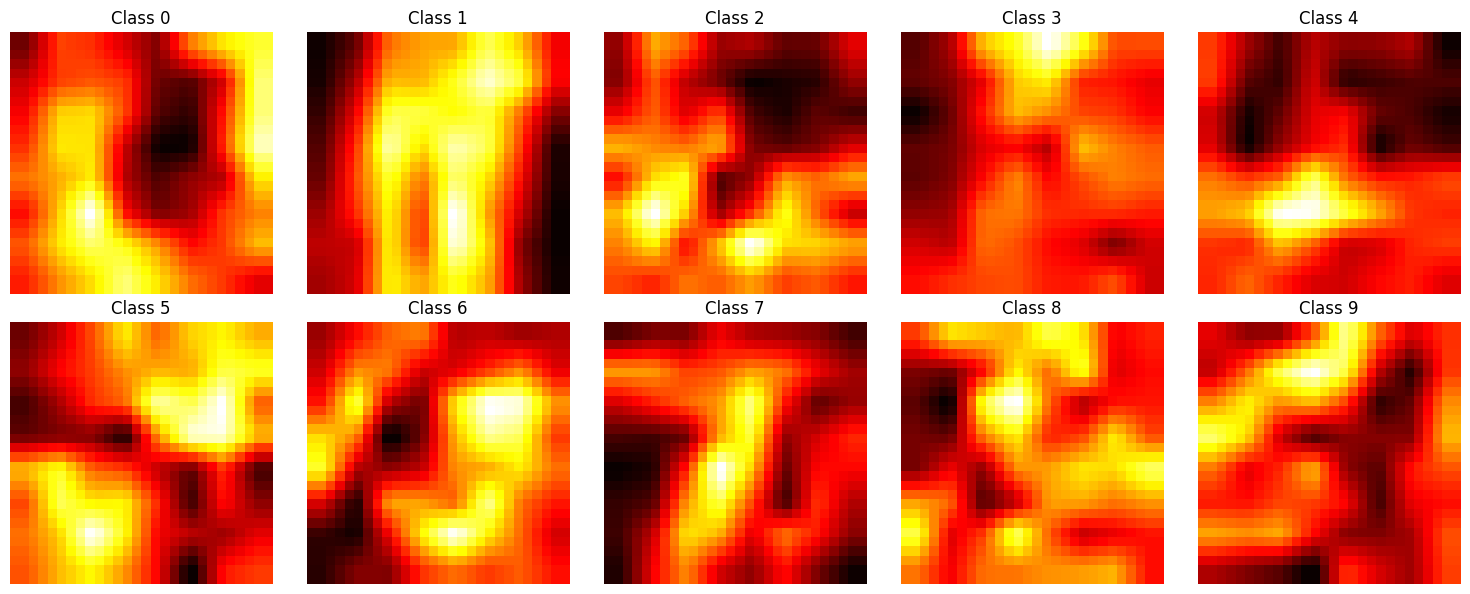

In [75]:
interpolated_images_by_class = {}

for class_label in range(number_of_classes):
    interpolated_img = accumulate_and_plot_average_saliency_map(training_data, generate_map, class_label_to_accumulate=class_label)
    interpolated_images_by_class[class_label] = interpolated_img

# Plot the interpolated images with their class labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    class_label = i
    interpolated_img = interpolated_images_by_class.get(class_label)
    if interpolated_img is not None:
        ax.imshow(interpolated_img, cmap='hot', interpolation='nearest')
        ax.axis('off')
        ax.set_title(f'Class {class_label}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


TODO:
    start implementing MaskTune for MNIST